In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.tabular import *

# Rossmann

## Data preparation

Time is often not handled with RNNs but rather with adding metadata, like e.g. which date is a monday or tuesday or payday. This is done e.g. by add_datepart.

This works well for simple time based tabular data, for complex states this would not work.

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [4]:
path = Path('data/rossmann/')
train_df = pd.read_pickle(path/'train_clean')

FileNotFoundError: [Errno 2] No such file or directory: 'data/rossmann/train_clean'

In [ ]:
train_df.head().T

In [ ]:
n = len(train_df); n

### Experimenting with a sample

Pre-processors.

Run once before any training set, then put to validation & test set.

Image Recognition with set of classes with breeds to turn into numbers --> pre - processor to ensure classes for training set are the same as for the validation set

In [ ]:
idx = np.random.permutation(range(n))[:2000] ## grab 2000 ids at random and below 5 columns
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [1]:
small_train_df.head() ## panda missing is NaN

NameError: name 'small_train_df' is not defined

In [ ]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
428412,921,2,NaN,840.0,89,8343
428541,1050,2,"Mar,Jun,Sept,Dec",13170.0,78,4945
428813,209,1,"Jan,Apr,Jul,Oct",11680.0,85,4946
430157,414,6,"Jan,Apr,Jul,Oct",6210.0,88,6952
431137,285,5,NaN,2410.0,57,5377


In [5]:
## take these strings, find all possible unique values, list, turn string into numbers
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

NameError: name 'small_cat_vars' is not defined

In [ ]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
428412,NaN,2,NaN,840.0,89,8343
428541,1050.0,2,"Mar,Jun,Sept,Dec",13170.0,78,4945
428813,NaN,1,"Jan,Apr,Jul,Oct",11680.0,85,4946
430157,414.0,6,"Jan,Apr,Jul,Oct",6210.0,88,6952
431137,285.0,5,NaN,2410.0,57,5377


In [ ]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [ ]:
small_train_df['PromoInterval'].cat.codes[:5] ## -1 is NaN m

280   -1
584   -1
588    1
847   -1
896    1
dtype: int8

In [ ]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [ ]:
## fact that sth is missing is recorded here with the CompetitionDistance
small_train_df[small_train_df['CompetitionDistance_na'] == True] 

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
78375,622,5,NaN,2380.0,71,5390,True
161185,622,6,NaN,2380.0,91,2659,True
363369,879,4,"Feb,May,Aug,Nov",2380.0,73,4788,True


### Preparing full data set

In [ ]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [ ]:
len(train_df),len(test_df)

(844338, 41088)

In [ ]:
procs=[FillMissing, Categorify, Normalize] ## prep preprocessors

In [ ]:
## categorical vars and continuous
## some categorical vars could be continuous. 
## E.g. for the day we want an embedding to see for example the salary pay day

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [ ]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [ ]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [ ]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [ ]:
valid_idx = range(cut)

In [ ]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [ ]:
## with int we do a classification, with float fast ai would a regression
## a.o.t. we pass in the pre-processors, label, split valid vs train
## label_cls is 
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())
## why log = True? RMSPE kaggle competition
## Common: dollar amount of sales

In [ ]:
doc(FloatList)

## Model

In [ ]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [6]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
## y_range is also a log
## from 1000 to 500, so 500.000 weights --> overfit
## Hence, we need regularisation: weight decay / 
## ps: drop out probability per layer




NameError: name 'data' is not defined

Dropout:

http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf (a.o. Geoffrey Hinton)
- at random we throw away some activations, hence the things that were connected to it are also gone
- throw away with probability p = .75
- one can also delete inputs (not common), we do not throw away weights
- in one mini batch throw away some, in other throw away others. others are added again
- no one activation can memorise a particular image (that is overfitting)
- with dropout this is difficult
- too much dropout implies underfitting
- ps: p value per layer as a list
- training time: back propagation
- at test time we turn off drop out, so now we have a lot of activations
- at pytorch and others, we do this at training time

emb_drop: 
    ## special drop out on embedding layer
    ## lets delete at random some results of that embedding
    ## emporically, mebedding dropout works well

Batch Normalisation:
    - https://arxiv.org/pdf/1502.03167.pdf
    - why does it work ?
        https://arxiv.org/pdf/1805.11604.pdf
        it does not reduce 'covariant shift' even if, 
    - in reality batch norm makes things less bumpy
    - therefore you can increase the learning rate
    - Algorithm: minute 58.50
        - take a mini batch
        - in the last step we take kind of a bias to multiply 
        
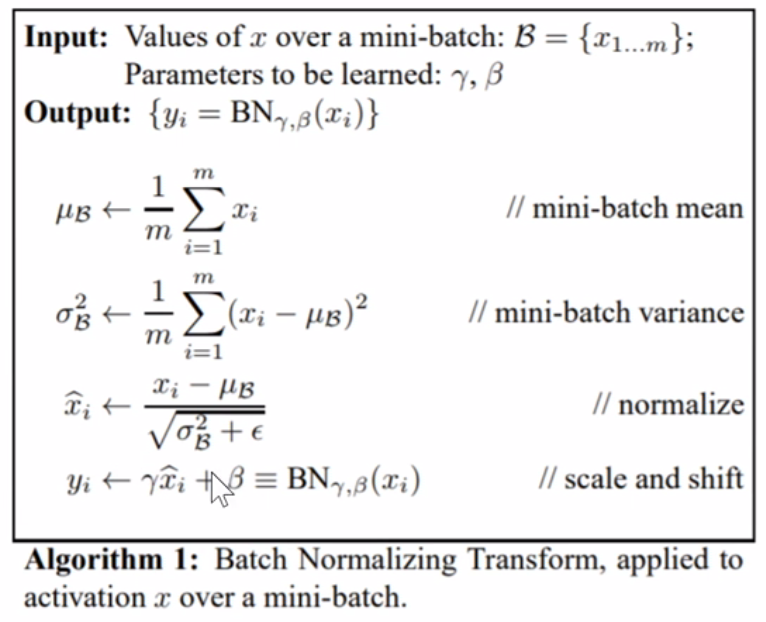
        
        - why does it work ? 1:00:40
        - y_hat = f(w1,w2, ..., wn, X) 
            the value of our predictyion y_hat is a function of various weights and inputs to layers
        - Loss: actuals minus predicted_squared
        - Example: 
            movie review outcomes between 1-5
            imagine our current weights are between -1 and 1, way off (scale, mean)
            - try a new set of weights to improve, but note these weights are interconnected --> COMPLEX
            - y_hat = f(w1,w2, ..., wn, X) * g + b
            - with g and b we can shift the outputs up and down and in and out
            - there are other types of normalisation (weight norm e.g.)
1:07:15 Q&A
- dropout vs use weight decay (not L2)
    in practice, typically you want a weight decay and often drop out
- always batch norm
- data augmentation
        
        



In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 17)
    (5): Embedding(3, 2)
    (6): Embedding(26, 14)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 13)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 12)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 2)
    (23): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=229, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
len(data.train_ds.cont_names)

16

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


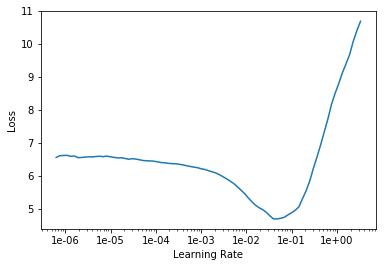

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

Total time: 14:18
epoch  train_loss  valid_loss  exp_rmspe
1      0.021467    0.023627    0.149858   (02:49)
2      0.017700    0.018403    0.128610   (02:52)
3      0.014242    0.015516    0.116233   (02:51)
4      0.012754    0.011944    0.108742   (02:53)
5      0.010238    0.012665    0.105895   (02:52)



In [ ]:
learn.save('1')

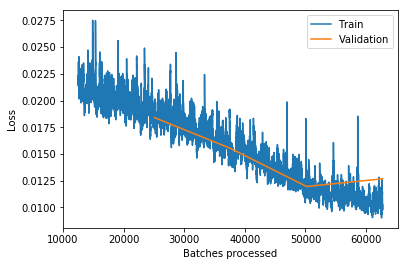

In [ ]:
learn.recorder.plot_losses(last=-1)

In [ ]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5, 3e-4)

Total time: 13:52
epoch  train_loss  valid_loss  exp_rmspe
1      0.018280    0.021080    0.118549   (02:49)
2      0.018260    0.015992    0.121107   (02:50)
3      0.015710    0.015826    0.113787   (02:44)
4      0.011987    0.013806    0.109169   (02:43)
5      0.011023    0.011944    0.104263   (02:42)



In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012831,0.012518,0.106848
2,0.011145,0.013722,0.109208
3,0.011676,0.015752,0.115598
4,0.009419,0.012901,0.107179
5,0.009156,0.011122,0.103746


(10th place in the competition was 0.108)

## fin